In [41]:
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

from dataset import load_dataset_from_path
from datasets import load_dataset, Dataset
from utils import partition_df

In [42]:
ROOT_DATA_DIR = "../data/Arithmetic/"
RAW_DATA_PATH = os.path.join(ROOT_DATA_DIR, "arithmetic_dataset.csv")
df = load_dataset_from_path(RAW_DATA_PATH)
df = df.drop_duplicates(["query"])
df

,query_no_mod,query,prior_answer,context,ctx_answer,query_depth,ctx_depth
0,(2 * 4) - 3,(2 * 4) - 3 =,5,(2 * 4) - 3 = 9,9,2,2
1,((5 * 1) + 3) - 3,((5 * 1) + 3) - 3 =,5,3 = 7,5,3,0
2,(4 + 8) - 8,(4 + 8) - 8 =,4,8 = 3,4,2,0
3,2 + 0,2 + 0 =,2,0 = 4,6,1,0
4,(1 + 2) + 1,(1 + 2) + 1 =,4,1 = 4,10,2,0
...,...,...,...,...,...,...,...
995,((2 + 9) - 8) + 2,((2 + 9) - 8) + 2 =,5,2 = 3,7,3,0
996,(8 - 3) - 2,(8 - 3) - 2 =,3,2 = 0,5,2,0
997,((5 - 4) * 6) - 5,((5 - 4) * 6) - 5 =,1,5 = 8,16,3,0
998,((6 - 5) + 5) - 6,((6 - 5) + 5) - 6 =,0,6 = 1,0,3,0


### EDA

In [43]:
df.value_counts(["query"])

query              
((0 * 0) * 7) * 8 =    1
(5 - 2) * 1 =          1
(5 + 4) - 0 =          1
(5 + 4) - 4 =          1
(5 + 5) - 5 =          1
                      ..
((8 + 5) - 7) + 0 =    1
((8 + 6) - 0) * 0 =    1
((8 + 6) - 2) - 4 =    1
((8 + 7) - 3) - 6 =    1
9 - 9 =                1
Name: count, Length: 1000, dtype: int64

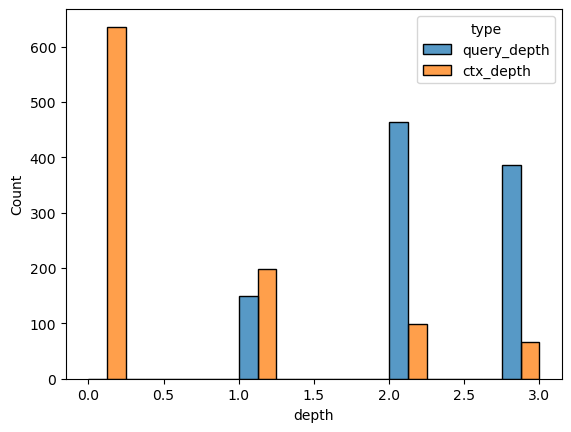

In [44]:
def plot_depth_dist(df):
    fig, ax = plt.subplots()
    sns.histplot(
        data=df.melt(id_vars="query", value_vars=["query_depth", "ctx_depth"], var_name="type", value_name="depth"), 
        x="depth",
        multiple='dodge',
        hue="type",
        ax=ax
    )
plot_depth_dist(df)
# Should we try to even this out more?

### Augment with intent

In [45]:
df_prior = df.copy()
df_prior["weight_context"] = 0
df_prior["answer"] = df_prior["prior_answer"]

df_ctx = df.copy()
df_ctx["weight_context"] = 1
df_ctx["answer"] = df_ctx["ctx_answer"]

df_all = pd.concat([df_prior, df_ctx], axis=0)
df_all.sort_values(["query", "context"])
df_all["answer"] = df_all["answer"].apply(str)
df_all["prior_answer"] = df_all["prior_answer"].apply(str)
df_all["ctx_answer"] = df_all["ctx_answer"].apply(str)

### Train/val/test split

In [46]:
train_df, val_df, test_df = partition_df(df_all, columns=["query"])
train_df = train_df.sort_values(["query", "context"])
val_df = val_df.sort_values(["query", "context"])
test_df = test_df.sort_values(["query", "context"])

train_df.info(), val_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 447 to 934
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    1280 non-null   object
 1   query           1280 non-null   object
 2   prior_answer    1280 non-null   object
 3   context         1280 non-null   object
 4   ctx_answer      1280 non-null   object
 5   query_depth     1280 non-null   int64 
 6   ctx_depth       1280 non-null   int64 
 7   weight_context  1280 non-null   int64 
 8   answer          1280 non-null   object
dtypes: int64(3), object(6)
memory usage: 100.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 125 to 171
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    320 non-null    object
 1   query           320 non-null    object
 2   prior_answer    320 non-null    object
 3   context         320 non-null    obje

(None, None, None)

In [47]:
train_df.value_counts("weight_context")

weight_context
0    640
1    640
Name: count, dtype: int64

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1280 entries, 447 to 934
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   query_no_mod    1280 non-null   object
 1   query           1280 non-null   object
 2   prior_answer    1280 non-null   object
 3   context         1280 non-null   object
 4   ctx_answer      1280 non-null   object
 5   query_depth     1280 non-null   int64 
 6   ctx_depth       1280 non-null   int64 
 7   weight_context  1280 non-null   int64 
 8   answer          1280 non-null   object
dtypes: int64(3), object(6)
memory usage: 100.0+ KB


In [49]:
full_dir = os.path.join(ROOT_DATA_DIR, "splits", "base")
os.makedirs(full_dir, exist_ok=True)
train_df.to_csv(
    os.path.join(full_dir, "train.csv"),
    index=False,
)
val_df.to_csv(
    os.path.join(full_dir, "val.csv"),
    index=False,
)
test_df.to_csv(
    os.path.join(full_dir, "test.csv"),
    index=False,
)

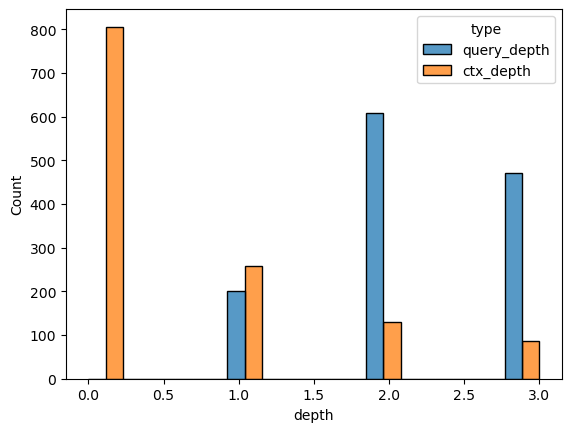

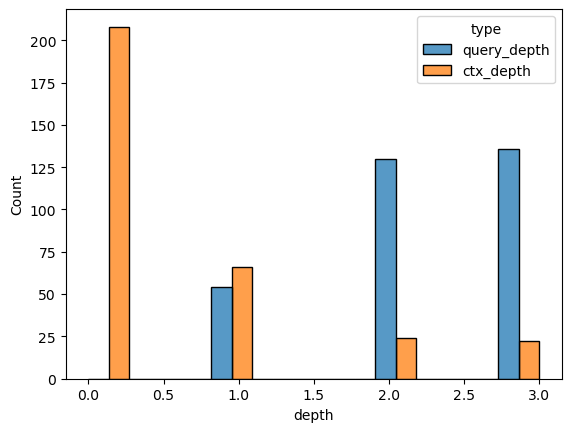

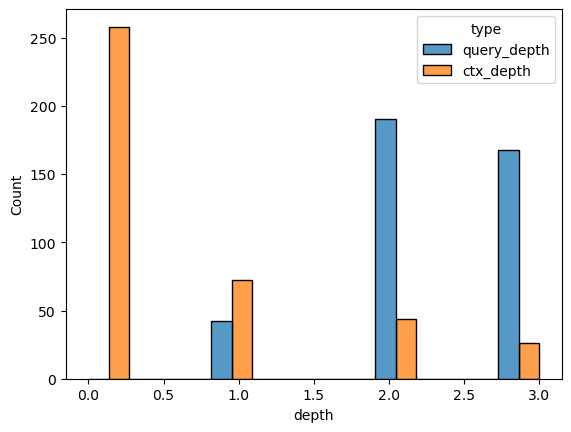

In [50]:
plot_depth_dist(train_df)
plot_depth_dist(val_df)
plot_depth_dist(test_df)
